# Files import & join

In [2]:
import os, pandas as pd

# files from "features_exploration" out (.csv)
out_path = ".." + os.sep + "out" + os.sep
dataframes = []
features = []

# file read (filenames = features names = column name)
for result_file in os.listdir(out_path):
    features.append(result_file)
    dataframes.append(pd.read_csv(out_path + result_file))

# directory not empty check
if len(dataframes) == 0:
    print("No csv files in " + out_path)
    exit(1)
    
# joins all data!
final_data = dataframes[0]
for dataframe in dataframes[1:]:
    final_data = pd.merge(final_data, dataframe, suffixes=("", "_fn"), on="id", how="outer")
    
# picks only id, label and features columns (mergeing produces also a lot of junk)
columns = ["id", "label"]
columns.extend(features)
final_data = final_data[columns]


# Features histograms

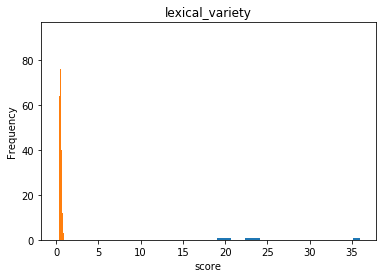

In [21]:
for feature in features:
    histogram = final_data[feature].plot.hist(bins=20)
    plt.title(feature)
    plt.xlabel("score")

# Features distribution boxplot

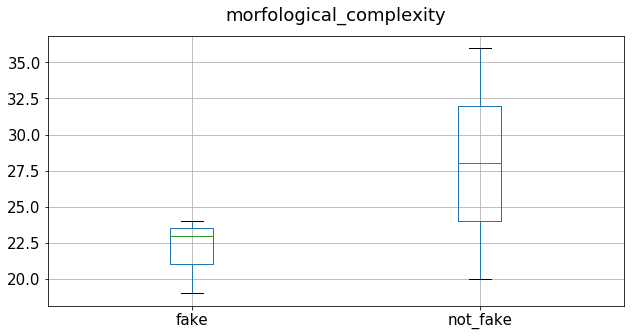

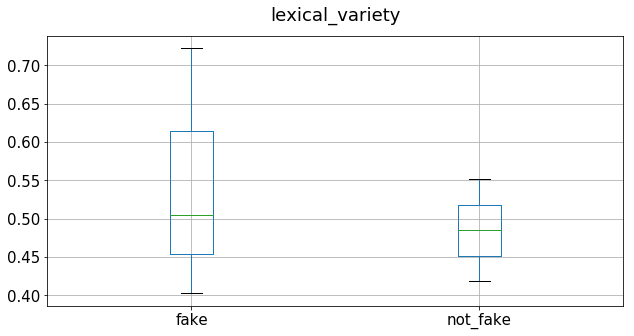

In [15]:
import numpy as np, matplotlib.pyplot as plt


''' PLOTTING RESULTS '''

# parameters
width = 10
height = 5
axes_fontsize = 15
labels_fontsize = 18

# boxplot: distribution of fake - not_fake for every feature
for feature in features:
    # plot
    boxplot = final_data.boxplot(by="label", column=feature, figsize=(width, height), fontsize=axes_fontsize)
    # blank labels
    [axis.set_xlabel('') for axis in np.asarray(boxplot).reshape(-1)]
    fig = np.asarray(boxplot).reshape(-1)[0].get_figure()
    # title
    plt.title("")
    fig.suptitle(feature, fontsize=labels_fontsize)

# Features combinations scatterplot

In [ ]:
import itertools

# parameters
width = 10
height = 5
axes_fontsize = 12
labels_fontsize = 18
legend_size = 18
point_size = 10
grid = True

# scatterplot per ogni combinazione di features:
for x_axis, y_axis in itertools.combinations(features, 2):
    # points colours (fake: red, non_fake: blue)
    colors = np.where(final_data["label"]=="fake","red","blue")
    # plot
    final_data.plot.scatter(x=x_axis, y=y_axis, figsize=(width, height), s=point_size, fontsize=axes_fontsize, \
                            c=colors, label="fake" if colors[0] == "red" else "not_fake")
    # legend
    plt.legend(prop={"size": legend_size})
    # labels size
    plt.xlabel(x_axis, fontsize=labels_fontsize)
    plt.ylabel(y_axis, fontsize=labels_fontsize)
    # grid?
    plt.grid(grid)
